In [18]:
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

In [19]:
model = xgb.XGBClassifier()
model.load_model('xgboost_abgabe.json')


In [20]:
model.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='dart', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=20,
              missing=-999, monotone_constraints='()', n_estimators=13,
              n_jobs=0, nthread=4, num_parallel_tree=1,
              objective='binary:hinge', predictor='auto', random_state=0, ...)>

**Feature Importances**

Weight: Occurance of feature over all trees

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

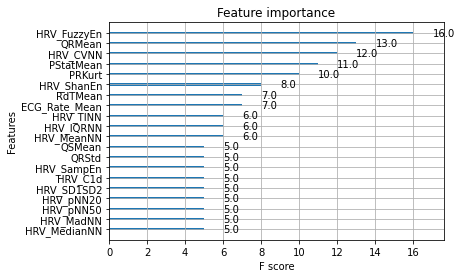

In [21]:
xgb.plot_importance(model, max_num_features=20, importance_type='weight')

Gain: Average gain of splits which use the feature

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

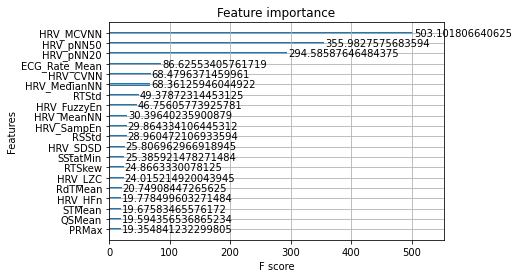

In [22]:
xgb.plot_importance(model, max_num_features=20, importance_type='gain')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

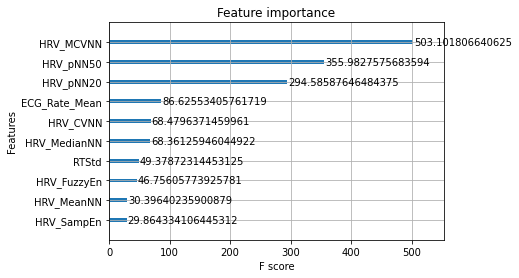

In [23]:
xgb.plot_importance(model, max_num_features=10, importance_type='gain')

Total gain: accumulated gain of feature

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

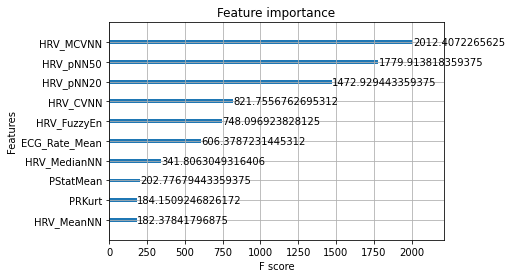

In [24]:
xgb.plot_importance(model, max_num_features=10, importance_type='total_gain')

Cover: average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

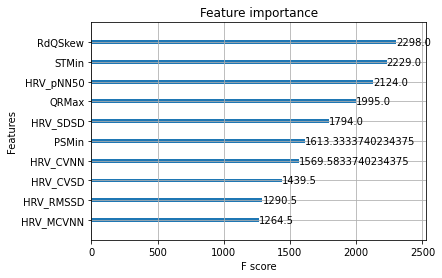

In [25]:
xgb.plot_importance(model, max_num_features=10, importance_type='cover')

Top 50 Features sorted by gain

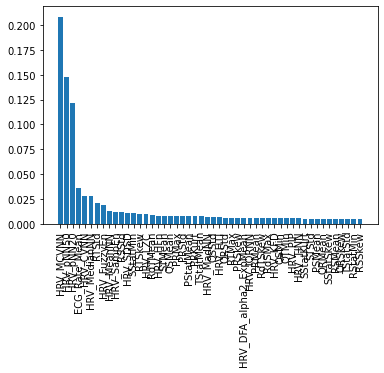

In [26]:
features = model.feature_importances_
featnames = model.feature_names_in_
sortednames = [x for _, x in sorted(zip(features, featnames))]
sortedfeat = sorted(features)
sortedfeat.reverse()
sortednames.reverse()

plt.bar(sortednames[0:50], sortedfeat[0:50])
plt.xticks(rotation='vertical')
plt.show()

**Combined Feature Ranking of weight and gain**

Top 20 Features sorted by gain with weight and gain

96


<AxesSubplot:>

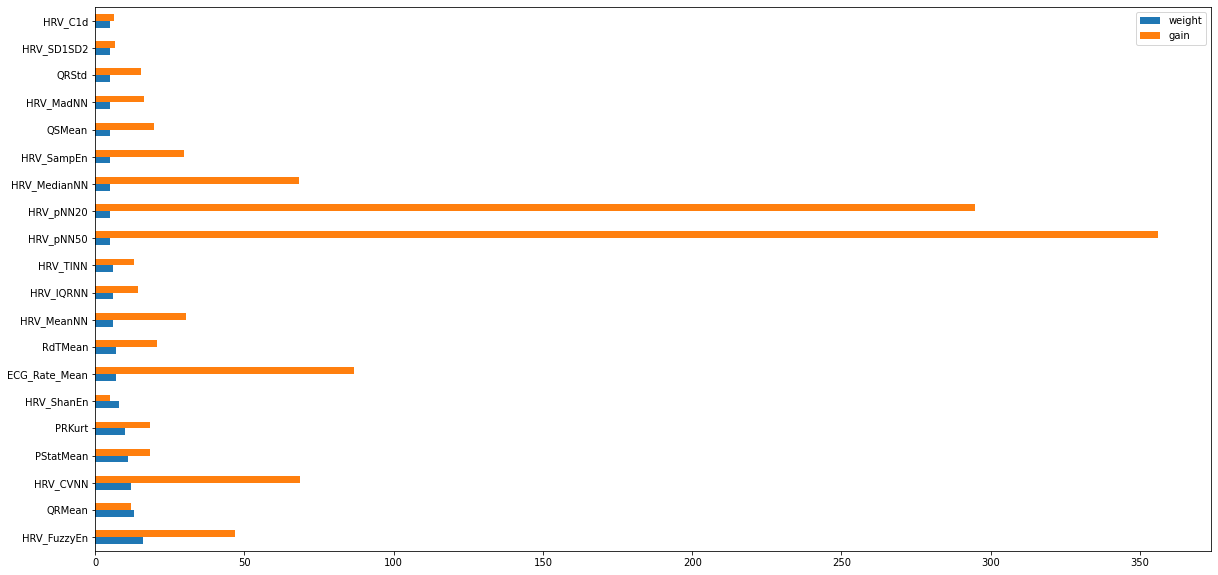

In [27]:
feature_important_w = model.get_booster().get_score(importance_type='weight')
feature_important_g = model.get_booster().get_score(importance_type='gain')

keys_W = list(feature_important_w.keys())
values_W = list(feature_important_w.values())
print(len(keys_W))

keys_G = list(feature_important_g.keys())
values_G = list(feature_important_g.values())

data = pd.DataFrame(data={'weight':values_W, 'gain':values_G}, index=keys_W).sort_values(by = "gain", ascending=False)
data.nlargest(20, columns=["weight","gain"]).plot(kind='barh', figsize = (20,10)) ## plot top 40 features

Custom ranking: features sorted by rank in gain and weight summed

In [28]:
wranks = sorted(zip(values_W,keys_W), key = lambda x: x[0])
values_W, keys_W = zip(*wranks)
granks = sorted(zip(values_G,keys_G), key = lambda x: x[0])
values_G, keys_G = zip(*granks)
#print(keys_w)
print(values_W[0], values_W[1], values_W[-1])
print(values_G[0], values_G[1], values_G[-1])
indicesw = list(range(len(keys_W)))
indicesg = list(range(len(keys_W)))
print(indicesw)
print(keys_W[-1])
print(keys_G[-1])
wranks = zip(keys_W, indicesw)
granks = zip(keys_G, indicesg)
values_w = values_W
values_g= values_G

wranks = sorted(wranks, key = lambda x: x[0])
granks = sorted(granks, key = lambda x: x[0])

wranks.reverse()
granks.reverse()

keys_w, indicesw = zip(*wranks)
keys_g, indicesg = zip(*granks)


rank = [x + y for x, y in zip(indicesw, indicesg)]

ranks = sorted(zip(rank, keys_w, keys_g, values_w, values_g), key = lambda x: x[0])
ranks.reverse()
rank, keys_w, keys_g, values_w, values_g = zip(*ranks)

# print(rank[0], keys_g[0], keys_w[0])
# print(rank[-1], keys_g[-1], keys_w[-1])

rank = [x / (2*len(rank)) for x in rank]


1.0 1.0 16.0
0.031036376953125 0.138916015625 503.101806640625
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
HRV_FuzzyEn
HRV_MCVNN


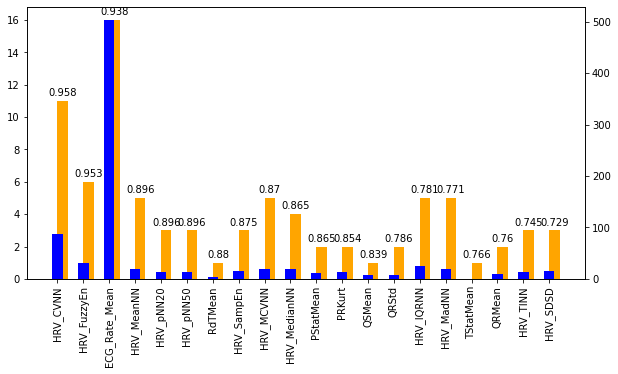

In [29]:
lim=20

fig, ax = plt.subplots(figsize=(10,5))
plt.xticks(rotation='vertical')
ax2=ax.twinx()
#ax3=ax2.twinx()
p1 = ax.bar(keys_w[0:lim], values_w[0:lim], label='weight',color='orange',align='edge', width=0.4)
p2 = ax2.bar(keys_g[0:lim], values_g[0:lim], label='gain', color='blue', width=0.4)
#p2 = ax3.bar(keys_w[0:lim], rank[0:lim], label='gain', width=0.4, color='red')
ax.bar_label(p1, labels=np.round(rank[0:lim],3), padding=3)
plt.show()

In [30]:
with open('Neurokit_Dataset.pkl', 'rb') as mit:
    dat = pickle.load(mit)

featkeys= list(keys_W)[0:15]
featkeys.append('TYPE')
dat['TYPE'].replace('A', 1, inplace=True)
dat['TYPE'].replace('N', 0, inplace=True)
print
dat2 = dat[featkeys]

**Top Feature correlations to Type (Normal or Afib)**

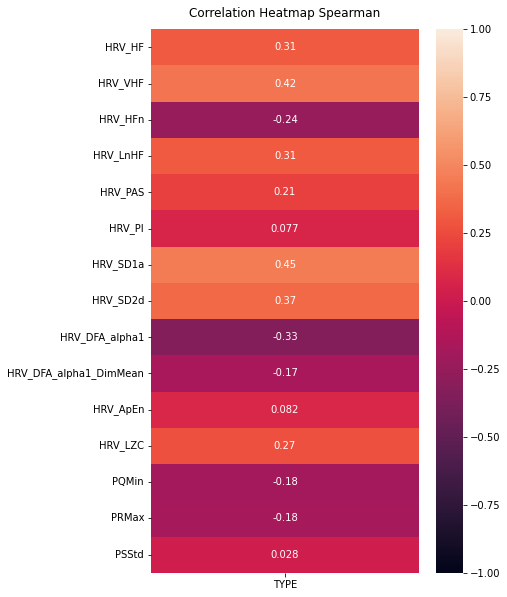

In [31]:
plt.figure(figsize=(6, 10))
heatmap = sns.heatmap(dat2.corr(method='spearman')['TYPE'].to_frame().drop('TYPE'), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap Spearman', fontdict={'fontsize':12}, pad=12);

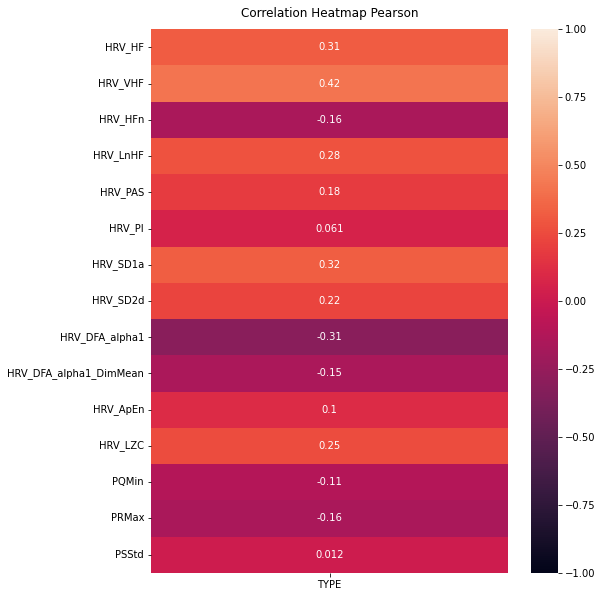

In [32]:
plt.figure(figsize=(8, 10))
heatmap = sns.heatmap(dat2.corr(method='pearson')['TYPE'].to_frame().drop('TYPE'), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap Pearson', fontdict={'fontsize':12}, pad=12);

In [33]:
#sns.pairplot(dat2.sample(500))
#plt.show()